In [1]:
import numpy as np
from DP.utils import fisher_gradient, fisher_information_privatized, is_epsilon_private
import cvxpy as cp

def project_onto_feasible_set(Q, epsilon):
    n_plus_1 = Q.shape[0]
    Q_var = cp.Variable((n_plus_1, n_plus_1))
    Q_param = Q

    # Objective: minimize ||Q_var - Q_param||_F^2
    objective = cp.Minimize(cp.log_sum_exp(Q_var - Q_param))

    # Constraints
    constraints = []

    # Non-negativity
    constraints += [Q_var >= 0]

    # Column sums
    for j in range(n_plus_1):
        constraints += [cp.sum(Q_var[:, j]) == 1]

    # ε-Differential Privacy constraints
    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_plus_1):
        for j in range(n_plus_1):
            for j_prime in range(n_plus_1):
                if j < j_prime:
                    constraints += [Q_var[i, j] - exp_neg_eps * Q_var[i, j_prime] >= 0]
                    constraints += [exp_eps * Q_var[i, j_prime] - Q_var[i, j] >= 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    return Q_var.value


def linesearch(p_theta, p_theta_dot, epsilon, q, n, theta):
    max_iters = 100
    alpha_init = 0.1
    beta = 0.8
    c = 1e-4
    history = [q]

    for t in range(max_iters):
        I_current = fisher_information_privatized(q, n, theta)
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)

        alpha = alpha_init
        while True:
            q_new = q + alpha * grad_I
            q_new = project_onto_feasible_set(q_new, epsilon)

            I_new = fisher_information_privatized(q_new, n, theta)

            if I_new >= I_current + c * alpha * np.sum(grad_I + (q_new - q)):
                break
            else:
                alpha *= beta

            if alpha < 1e-8:
                print("Line search failed to find a suitable step size.")

        if np.allclose(q, q_new):
            status = f"Converged after {t+1} iterations."
            break

        if abs(I_current - I_new) < 1e-8:
            status = f"Converged after {t+1} iteratons."
            break

        q = q_new
        history.append(q)
        status = "Max iterations reached without convergence"
    
    return {"Q_matrix": q, "status": status, "history": history}

In [2]:
from scipy.stats import binom
from DP.utils import binom_derivative

n = 3
theta = 0.5
epsilon = 1.0

p_theta = binom.pmf([0, 1, 2, 3], 3, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(4)]

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.01)
print(is_epsilon_private(Q_init, epsilon))

Q_init = project_onto_feasible_set(Q_init, epsilon)

result = linesearch(p_theta, p_theta_dot, epsilon, Q_init, n, theta)

print(result["Q_matrix"])
print(result["status"])
print(result["history"])

True
[[0.39195056 0.39195071 0.14419025 0.14418976]
 [0.13425502 0.13425415 0.36493669 0.36493695]
 [0.13469199 0.13469111 0.36612426 0.36612499]
 [0.33910242 0.33910402 0.1247488  0.1247483 ]]
Converged after 7 iterations.
[array([[0.25538005, 0.25169863, 0.23895317, 0.24787591],
       [0.253317  , 0.22904232, 0.25074856, 0.24401485],
       [0.250989  , 0.2494365 , 0.25908019, 0.25261986],
       [0.24031395, 0.26982256, 0.25121808, 0.25548938]]), array([[0.26458945, 0.26085387, 0.22963565, 0.23861245],
       [0.2475643 , 0.22329337, 0.25650823, 0.24977104],
       [0.24600455, 0.24446465, 0.26408991, 0.25761696],
       [0.24184171, 0.2713881 , 0.24976621, 0.25399955]]), array([[0.29046841, 0.28629964, 0.20289137, 0.21230094],
       [0.23114199, 0.20689264, 0.2729722 , 0.26621406],
       [0.23223252, 0.2308015 , 0.27807935, 0.27149765],
       [0.24615708, 0.27600622, 0.24605707, 0.24998735]]), array([[0.35945742, 0.35493632, 0.13223682, 0.13670073],
       [0.18527888, 0.160102

In [3]:
is_epsilon_private(result["Q_matrix"], epsilon)

False

In [4]:
for m in result["history"]:
    print(fisher_information_privatized(m, n, theta))

0.001599283784769006
0.012729655618338668
0.10148311564639895
0.7813751468958264
1.7484396284228336
1.9219670537372107
1.9219550336156683


In [5]:
n = 1
theta = 0.5
epsilon = 1.0

p_theta = binom.pmf([0, 1], 1, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(2)]

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.1)

Q_init = project_onto_feasible_set(Q_init, epsilon)
Q_init

array([[0.41607168, 0.52700714],
       [0.58392832, 0.47299286]])

In [6]:
is_epsilon_private(Q_init, epsilon)

True

In [7]:
I_current = fisher_information_privatized(Q_init, n, theta)
I_current

np.float64(0.04938672283618846)

In [8]:
grad_I = fisher_gradient(p_theta, p_theta_dot, Q_init)
grad_I

array([[-0.49819886,  0.44285049],
       [ 0.39781024, -0.44187746]])

In [9]:
alphas = np.linspace(0, 1, 100)
fisher_infs = list()
private = list()

for alpha in alphas:
    q_new = Q_init + alpha * grad_I

    I_new = fisher_information_privatized(q_new, n, theta)
    fisher_infs.append(I_new)
    private.append(is_epsilon_private(q_new, epsilon))

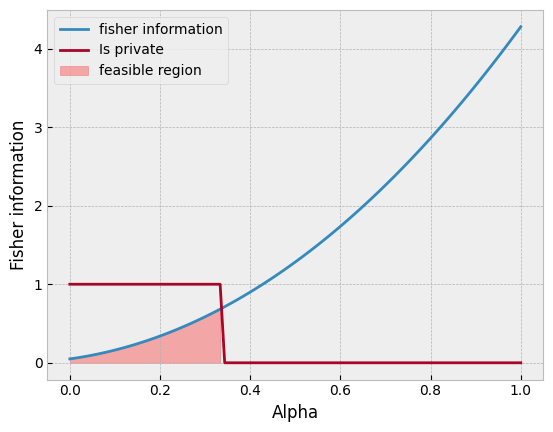

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

plt.plot(alphas, fisher_infs, label="fisher information")
plt.plot(alphas, [int(el) for el in private], label="Is private")
plt.fill_between(alphas, fisher_infs, where=private, color="red", alpha=0.3, label="feasible region")
plt.xlabel("Alpha")
plt.ylabel("Fisher information")
plt.legend()
plt.show()

In [11]:
max_alpha = alphas[private][-1]

q_new = Q_init + max_alpha * grad_I

In [12]:
q_new = project_onto_feasible_set(q_new, epsilon)
q_new

array([[0.26673668, 0.67446218],
       [0.73326332, 0.32553782]])

In [45]:
n = 1
theta = 0.1
epsilon = 1.0

p_theta = binom.pmf([0, 1], 1, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(2)]
p_theta

array([0.9, 0.1])

In [46]:
n_vals = 50

a_vals = np.linspace(0, 1, n_vals)
b_vals = np.linspace(0, 1, n_vals)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, n, theta))
        private.append(is_epsilon_private(q_mat, epsilon))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_90351/3589091248.py:33: RuntimeWarning: invalid value encountered in divide
  gradient_matrix = 2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta - np.outer(
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:172: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


In [47]:
from DP.linear_solver import linear_solver
from DP.utils import binom_optimal_privacy

opt_solutions, _, _ = binom_optimal_privacy(linear_solver(), n, epsilon, theta)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

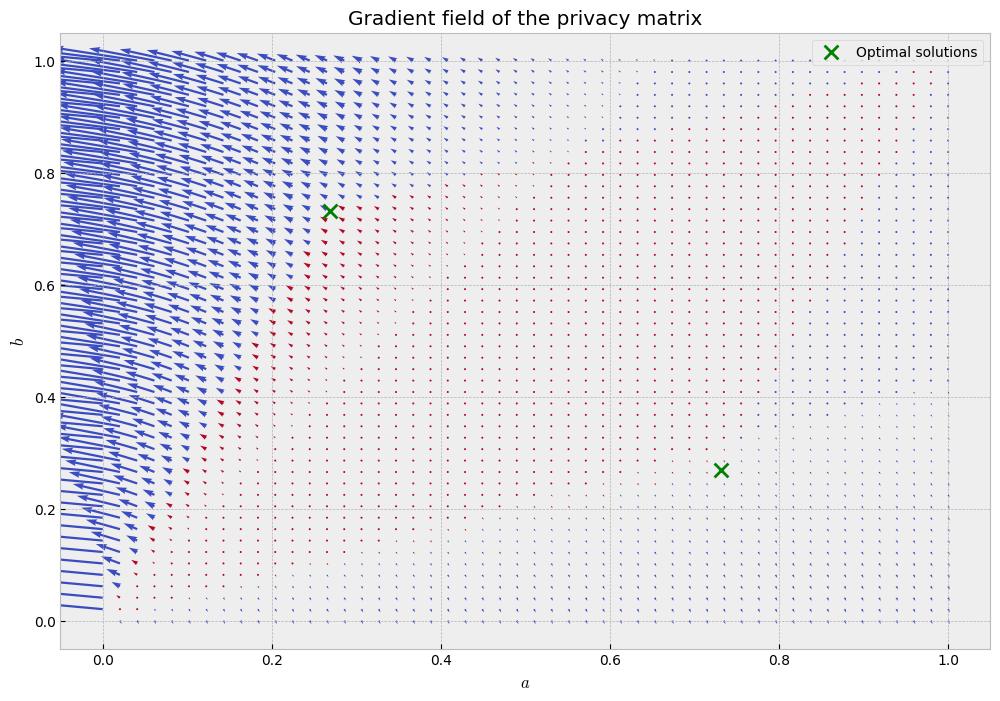

In [48]:
grads_a = np.array(grads_a).reshape((n_vals, n_vals), order="F")
grads_b = np.array(grads_b).reshape((n_vals, n_vals), order="F")
private = np.array(private).reshape((n_vals, n_vals), order="F")
fishers = np.array(fishers).reshape((n_vals, n_vals), order="F")

fig, ax = plt.subplots(figsize=(12, 8))
plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.title("Gradient field of the privacy matrix")
plt.show()

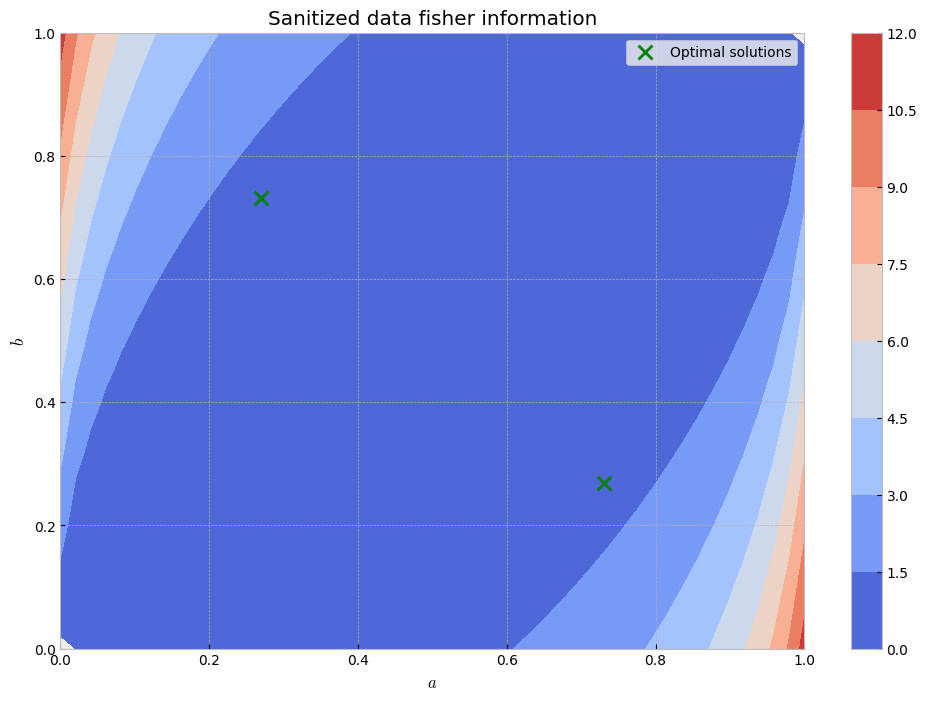

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title("Sanitized data fisher information")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()

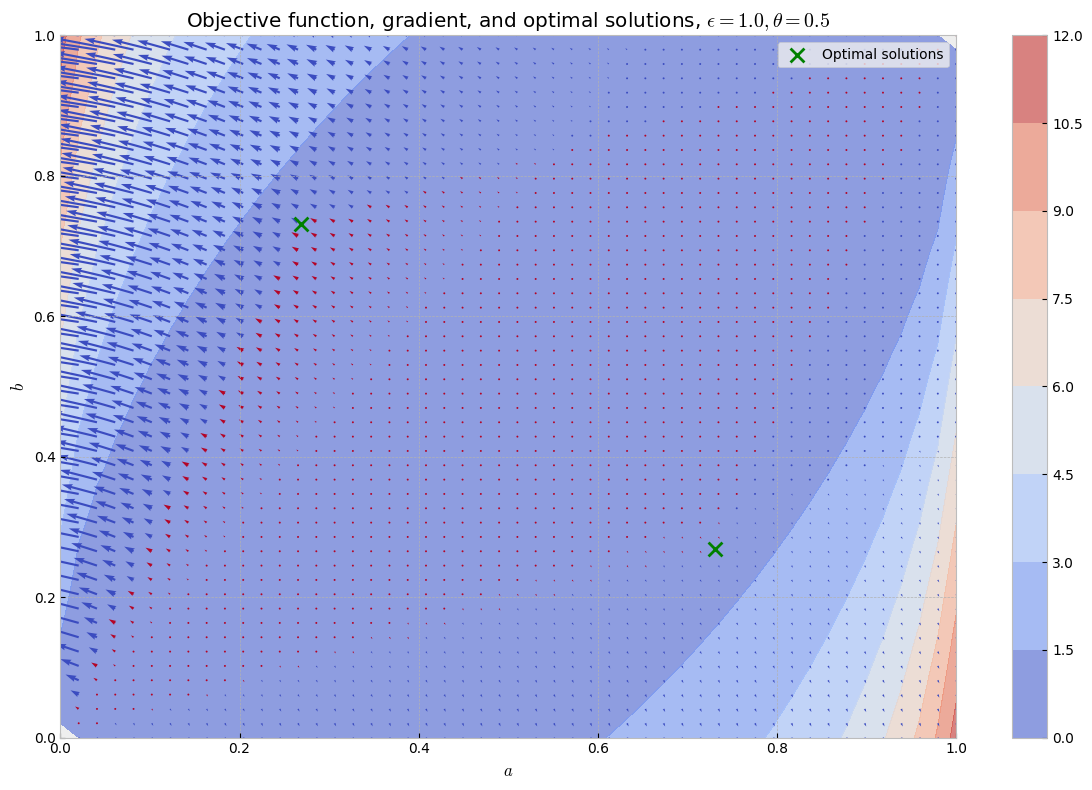

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.6)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.title(r"Objective function, gradient, and optimal solutions, $\epsilon = 1.0, \theta = 0.5$")
plt.tight_layout()
plt.show()

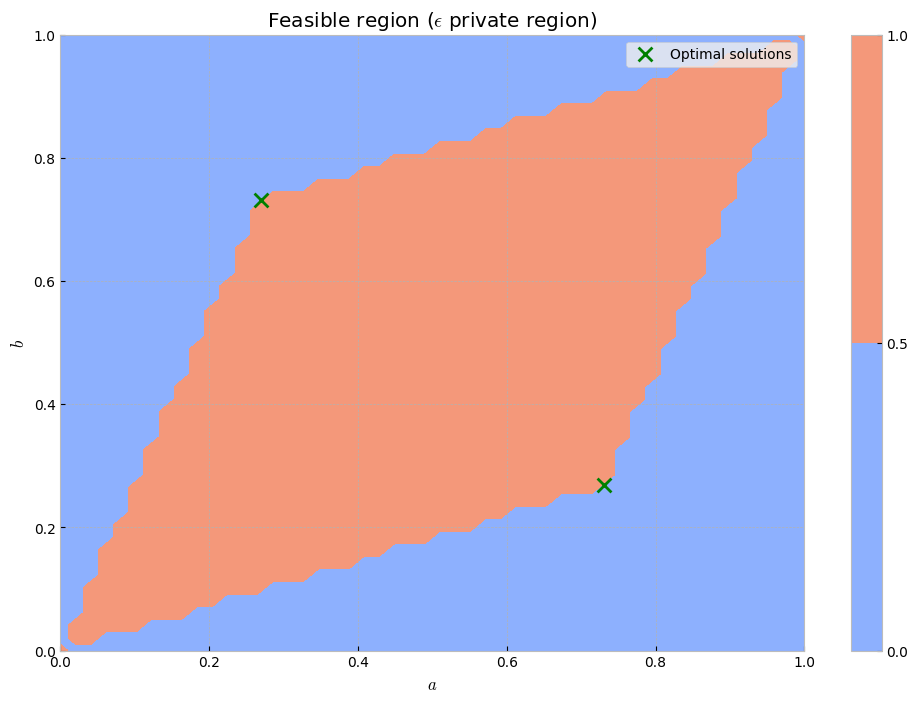

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, private, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title(r"Feasible region ($\epsilon$ private region)")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()

In [52]:
def projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon):
    history = [Q_init]
    grads = list()
    fish = fisher_information_privatized(Q_init, n, theta)
    q = Q_init

    for i in range(100):
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)
        # grad_I = grad_I / np.max(grad_I)
        #grad_I[-1, :] = 0
        q_raw = q + 0.1 * grad_I
        
        if is_epsilon_private(q_raw, epsilon):
            q_new = q_raw
        else:
            history.append(q_raw)
            q_new = project_onto_feasible_set(q_raw, epsilon)

        fish_next = fisher_information_privatized(q_new, n, theta)

        if np.allclose(q, q_new):
            status = f"Converged after {i+1} iterations."
            break

        if abs(fish - fish_next) < 1e-8:
            status = f"Converged after {i+1} iteratons."
            break
        
        q = q_new
        fish = fish_next

        grads.append(grad_I)
        history.append(q)

    return history, grads

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.1)
Q_init = project_onto_feasible_set(Q_init, epsilon)
history, grads = projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon)

In [53]:
all_history = np.array(history)

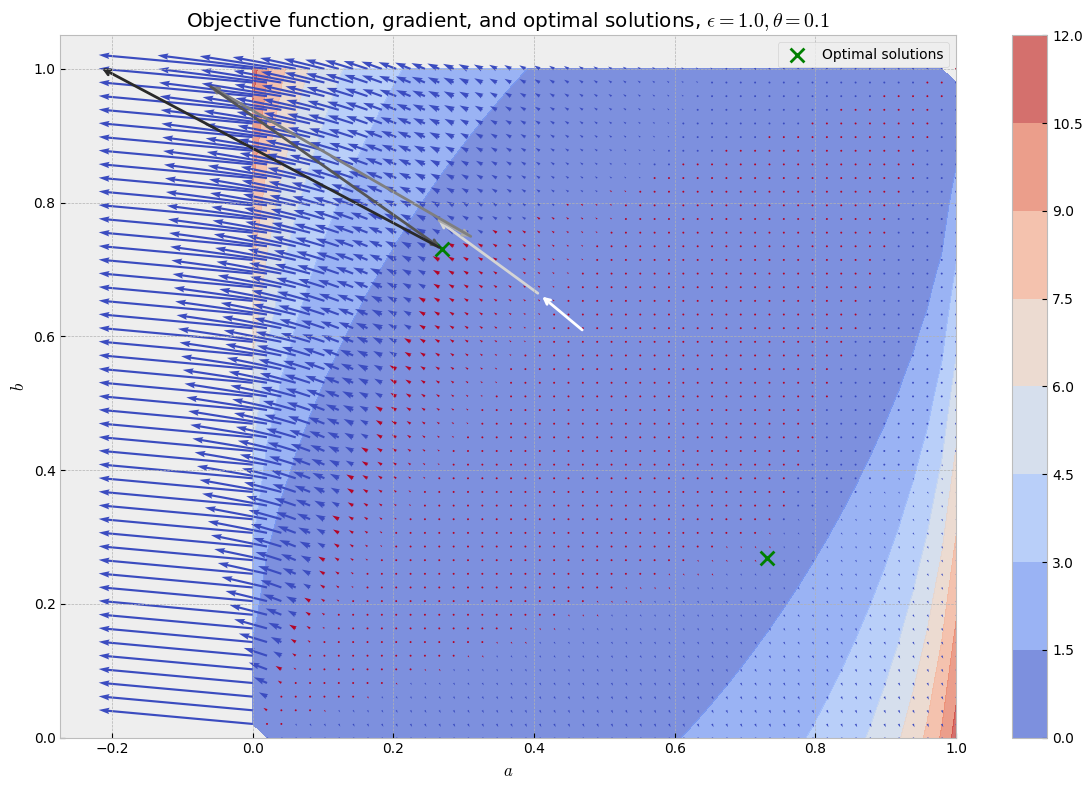

In [54]:
from matplotlib.patches import FancyArrowPatch

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))

fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
#plt.scatter(all_history[:,0,0], all_history[:,0,1], marker="x", s=100, label="Sample path", c=colors)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {epsilon}, \theta = {theta}$")
plt.tight_layout()
plt.show()

In [23]:
def fisher_gradient(
    p_theta: np.ndarray, p_theta_dot: np.ndarray, Q: np.ndarray
) -> np.ndarray:
    """
    Calculates the fisher information gradient at Q,
    given p_theta a vector of probabilities for a specific theta,
    and p_theta_dot a vector of derivatives wrt theta.

    Parameters
    ----------
    p_theta : np.ndarray
        vector of n probabilities for a specific theta
    p_theta_dot : np.ndarray
        vector of n derivatives of probability wrt theta
    Q : np.ndarray
        privacy matrix

    Returns
    -------
    np.ndarray
        gradient matrix pointing in the direction of greatest increase
    """

    # Compute Q @ p_theta and Q @ p_theta_dot for all rows
    Q_ptheta = Q @ p_theta  # Shape: (nrows,)
    Q_ptheta_dot = Q @ p_theta_dot  # Shape: (nrows,)

    # Precompute terms to avoid redundant calculations
    Q_ptheta_squared = np.power(Q_ptheta, 2)  # Element-wise squared values
    Q_ptheta_dot_squared = np.power(Q_ptheta_dot, 2)

    # Compute the numerator and denominator for all elements
    gradient_matrix = 2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta - np.outer(
        p_theta, Q_ptheta_dot_squared
    ) / Q_ptheta_squared

    return gradient_matrix.T

def fisher_gradient2(
    p_theta: np.ndarray, p_theta_dot: np.ndarray, Q: np.ndarray
) -> np.ndarray:
    """
    Calculates the fisher information gradient at Q,
    given p_theta a vector of probabilities for a specific theta,
    and p_theta_dot a vector of derivatives wrt theta.

    Parameters
    ----------
    p_theta : np.ndarray
        vector of n probabilities for a specific theta
    p_theta_dot : np.ndarray
        vector of n derivatives of probability wrt theta
    Q : np.ndarray
        privacy matrix

    Returns
    -------
    np.ndarray
        gradient matrix pointing in the direction of greatest increase
    """

    nrows, ncols = Q.shape
    gradient_matrix = np.zeros(Q.shape)

    for i in range(nrows):
        Q_row = Q[i]

        for j in range(ncols):
            Q_ptheta_dot = Q_row @ p_theta_dot
            Q_ptheta = Q_row @ p_theta

            gradient_matrix[i][j] = 2 * p_theta_dot[
                j
            ] * Q_ptheta_dot / Q_ptheta - p_theta[j] * np.power(
                Q_ptheta_dot, 2
            ) / np.power(
                Q_ptheta, 2
            )

    return gradient_matrix


In [24]:
q, _, _ = binom_optimal_privacy(linear_solver(), 1, 1.0, 0.01)
q

array([[0.26894142, 0.73105858],
       [0.73105858, 0.26894142]])

In [25]:
p_theta = binom.pmf(np.arange(2), 1, 0.01)
p_theta_dot = np.array([binom_derivative(i, 1, 0.01) for i in range(2)])

In [26]:
%%timeit
fisher_gradient(p_theta, p_theta_dot, q)

6.26 μs ± 198 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
%%timeit
fisher_gradient2(p_theta, p_theta_dot, q)

10.2 μs ± 95.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
fisher_gradient(p_theta, p_theta_dot, q)

array([[-6.20356013,  3.34997546],
       [ 0.87165393, -1.27633025]])

In [29]:
fisher_gradient2(p_theta, p_theta_dot, q)

array([[-6.20356013,  3.34997546],
       [ 0.87165393, -1.27633025]])